In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_ml_est = os.path.join(cwd, '..', 'tools', 'ml_estimation')
api_path_data = os.path.join(api_path_ml_est, 'data', "sonar.all-data.csv")

sys.path.append(api_path)
sys.path.append(api_path_ml_est)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch, torch.nn as nn
from functools import partial

from sir_ais_sampling import (sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from ebm_sampling import (MH_Transition, grad_energy, 
                          ais_dynamics, ais_vanilla_dynamics)

In [4]:
df = pd.read_csv(api_path_data, header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
inputs_df = df.drop(60, axis=1)
inputs_df['60'] = np.ones(inputs_df.shape[0])
targets_df = pd.get_dummies(df[60], dtype = np.int32)
inputs_df = torch.FloatTensor(inputs_df.to_numpy())
mine_y_df = torch.FloatTensor((targets_df['M'] * 2 - 1).to_numpy())


X_train, X_test, y_train, y_test = train_test_split(inputs_df, 
                                                    mine_y_df, 
                                                    test_size=0.30, 
                                                    random_state=42)
X_train_small = X_train[:, :-1]
X_test_small = X_test[:, :-1]

In [6]:
# normalization

mean = X_train_small.mean(0)
X_train_small = X_train_small - mean[None, :]
X_test_small = X_test_small - mean[None, :]
Sigma = 1/(X_train_small.shape[0] - 1) * X_train_small.T @ X_train_small
u, s, v = torch.svd(Sigma)
inv_sq_Sigma = v @ torch.diag(s**(-.5)) @ u.T
X_train_small = X_train_small @ inv_sq_Sigma
X_test_small = X_test_small @ inv_sq_Sigma

X_train = torch.cat([X_train_small, torch.ones(X_train_small.shape[0]).unsqueeze(-1)], -1)
X_test = torch.cat([X_test_small, torch.ones(X_test_small.shape[0]).unsqueeze(-1)], -1)

In [7]:
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef
        
    
    def func(self, w, X, y):
        """
        Get loss function value for data X, target y and coefficient w.

        Parameters
        ----------
        X : scipy.sparse.csr_matrix or numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        exp_part = y[:, None] * (X @ w.T)
        batch_sigmoid = torch.logaddexp(torch.zeros_like(exp_part), -exp_part) #np.logaddexp(0., -exp_part) 
        return batch_sigmoid.sum(axis = 0) + self.l2_coef*(torch.norm(w[:, :-1], dim = 1)**2)
    
    def log_prob_args(self, w, X, y):
        return -self.func(w, X, y)
    
def calculate_losses(history, loss_fun, X_train, X_test, y_train, y_test):
    loss_train = []
    loss_test = []
    for _, w in enumerate(history):
        train_loss = loss_fun(w, X_train, y_train).item()
        test_loss = loss_fun(w, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))
    return loss_train, loss_test

In [8]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

max_iter = 1, train_loss = 58.82589340209961, test_loss = 31.628095626831055
max_iter = 2, train_loss = 42.70588684082031, test_loss = 30.14116096496582
max_iter = 3, train_loss = 34.97071838378906, test_loss = 32.00033950805664
max_iter = 4, train_loss = 31.611862182617188, test_loss = 40.11181640625
max_iter = 5, train_loss = 29.965133666992188, test_loss = 43.63215637207031
max_iter = 6, train_loss = 29.751802444458008, test_loss = 44.90597915649414
max_iter = 7, train_loss = 29.72654914855957, test_loss = 45.38359069824219
max_iter = 8, train_loss = 29.70927619934082, test_loss = 45.69617462158203
max_iter = 9, train_loss = 29.697986602783203, test_loss = 45.78953552246094
max_iter = 10, train_loss = 29.69518280029297, test_loss = 45.75145721435547
max_iter = 11, train_loss = 29.694042205810547, test_loss = 45.632808685302734
max_iter = 12, train_loss = 29.69353485107422, test_loss = 45.54975128173828
max_iter = 13, train_loss = 29.693256378173828, test_loss = 45.556915283203125
ma

In [9]:
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9793103448275862
0.7777777777777778


In [10]:
dim = X_train.shape[1]
zeros_start = torch.zeros((1, dim))
train_loss = target.func(zeros_start, X_train, y_train).item()
test_loss = target.func(zeros_start, X_test, y_test).item()
print(train_loss, test_loss)

100.50631713867188 43.66825485229492


# SIR 

In [11]:
device = 'cpu'
scale_proposal = 1.0
random_seed = 42
proposal = init_independent_normal(scale_proposal, dim, device)

n_steps = 20000
#batch_size = 32
c = 0.01
N = 20
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
#start = proposal.sample([batch_size])
#start = torch.zeros((1, dim))
start = proposal.sample([1]) #w_clf
history = sir_correlated_dynamics(start, 
                                  target,
                                  proposal, 
                                  n_steps, 
                                  N, 
                                  alpha)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

65, Training loss: 64.551521, Test loss 93.253830
Iter: 19666, Training loss: 64.670593, Test loss 95.251831
Iter: 19667, Training loss: 64.555786, Test loss 94.679146
Iter: 19668, Training loss: 64.604538, Test loss 95.641266
Iter: 19669, Training loss: 64.398102, Test loss 97.761574
Iter: 19670, Training loss: 63.936996, Test loss 97.421150
Iter: 19671, Training loss: 63.936996, Test loss 97.421150
Iter: 19672, Training loss: 63.551155, Test loss 98.113800
Iter: 19673, Training loss: 63.652122, Test loss 98.639732
Iter: 19674, Training loss: 64.571098, Test loss 98.026588
Iter: 19675, Training loss: 65.570305, Test loss 99.788483
Iter: 19676, Training loss: 65.271729, Test loss 99.624435
Iter: 19677, Training loss: 65.271729, Test loss 99.624435
Iter: 19678, Training loss: 64.247345, Test loss 100.022247
Iter: 19679, Training loss: 63.734627, Test loss 99.725655
Iter: 19680, Training loss: 64.004318, Test loss 100.696877
Iter: 19681, Training loss: 63.928551, Test loss 101.690392
Ite

In [12]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.8620689655172413
0.7777777777777778


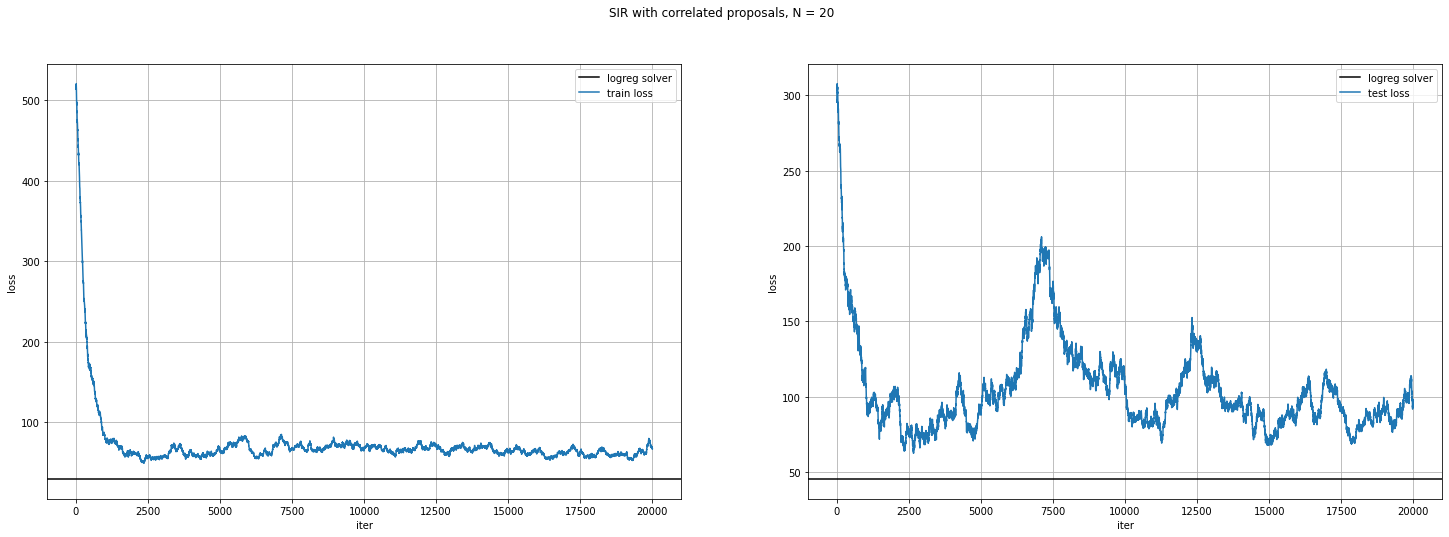

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [14]:
device = 'cpu'
scale_proposal = 1.0
random_seed = 42
dim = X_train.shape[1]
proposal = init_independent_normal(scale_proposal, dim, device)
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
n_steps = 10000
N = 10
batch_size = 1
start = proposal.sample([batch_size])
#start = w_clf

In [15]:
history = sir_independent_dynamics(start, 
                                   target,
                                   proposal, 
                                   n_steps, 
                                   N)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

st loss 198.988708
Iter: 9668, Training loss: 227.528229, Test loss 198.988708
Iter: 9669, Training loss: 227.528229, Test loss 198.988708
Iter: 9670, Training loss: 227.528229, Test loss 198.988708
Iter: 9671, Training loss: 227.528229, Test loss 198.988708
Iter: 9672, Training loss: 227.528229, Test loss 198.988708
Iter: 9673, Training loss: 227.528229, Test loss 198.988708
Iter: 9674, Training loss: 227.528229, Test loss 198.988708
Iter: 9675, Training loss: 227.528229, Test loss 198.988708
Iter: 9676, Training loss: 227.528229, Test loss 198.988708
Iter: 9677, Training loss: 227.528229, Test loss 198.988708
Iter: 9678, Training loss: 227.528229, Test loss 198.988708
Iter: 9679, Training loss: 227.528229, Test loss 198.988708
Iter: 9680, Training loss: 227.528229, Test loss 198.988708
Iter: 9681, Training loss: 227.528229, Test loss 198.988708
Iter: 9682, Training loss: 227.528229, Test loss 198.988708
Iter: 9683, Training loss: 227.528229, Test loss 198.988708
Iter: 9684, Training 

In [16]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.6068965517241379
0.5396825396825397


In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaler = torch.FloatTensor(scaler.transform(X_train))
# X_test_scaler = torch.FloatTensor(scaler.transform(X_test))
# X_train_small_scaler = X_train_scaler[:, :-1]
# X_test_small_scaler = X_test_scaler[:, :-1]
X_train_small_scaler = X_train_small
X_test_small_scaler = X_test_small
X_test_scaler = X_test
X_train_scaler = X_train

In [19]:
# num_iter = np.arange(100) + 1
# l2_coef = 0.5
# target = BinaryLogisticLoss(l2_coef)
# target.log_prob = partial(target.log_prob_args, 
#                           X = X_train,
#                           y = y_train)
# for max_iter in num_iter:
#     clf = LogisticRegression(random_state=42,
#                              tol=1e-7,
#                              max_iter = max_iter,
#                              C = 1.).fit(X_train_small_scaler, y_train)
#     w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
#     train_loss_clf = target.func(w_clf, X_train_scaler, y_train).item()
#     test_loss_clf = target.func(w_clf, X_test_scaler, y_test).item()
#     print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

In [20]:
# print(clf.score(X_train_small_scaler, y_train))
# print(clf.score(X_test_small_scaler, y_test))

In [21]:
# device = 'cpu'
# scale_proposal = 0.1
# random_seed = 42
# proposal = init_independent_normal(scale_proposal, dim, device)

# n_steps = 10000
# batch_size = 1
# c = 0.01
# N = 20
# alpha = (1 - c/dim)**0.5
# torch.manual_seed(random_seed)
# np.random.seed(random_seed)
# random.seed(random_seed)
# start = proposal.sample([batch_size])
# #start = torch.zeros((1, dim))
# #start = w_clf
# l2_coef = 0.5
# target = BinaryLogisticLoss(l2_coef)
# target.log_prob = partial(target.log_prob_args, 
#                           X = X_train_scaler,
#                           y = y_train)

# history = sir_correlated_dynamics(start, 
#                                   target,
#                                   proposal, 
#                                   n_steps, 
#                                   N, 
#                                   alpha)
# loss_train, loss_test = calculate_losses(history, target.func, 
#                                          X_train_scaler, X_test_scaler, y_train, y_test)

In [22]:
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
# name = f'SIR with сorrelated proposals, N = {N}'
# fig.suptitle(name)

# axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
# axs[0].set_xlabel('iter')
# axs[0].set_ylabel('loss')
# axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

# axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
# axs[1].set_xlabel('iter')
# axs[1].set_ylabel('loss')
# axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


# for ax in axs:
#     ax.grid()
#     ax.legend()

# plt.show()

In [23]:
# last_w = history[-1].numpy()
# clf.coef_ = last_w[:, :-1]
# clf.intercept_ = last_w[:, -1]
# print(clf.score(X_train_small_scaler, y_train))
# print(clf.score(X_test_small_scaler, y_test))

# AIS

In [24]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

max_iter = 1, train_loss = 58.82589340209961, test_loss = 31.628095626831055
max_iter = 2, train_loss = 42.70588684082031, test_loss = 30.14116096496582
max_iter = 3, train_loss = 34.97071838378906, test_loss = 32.00033950805664
max_iter = 4, train_loss = 31.611862182617188, test_loss = 40.11181640625
max_iter = 5, train_loss = 29.965133666992188, test_loss = 43.63215637207031
max_iter = 6, train_loss = 29.751802444458008, test_loss = 44.90597915649414
max_iter = 7, train_loss = 29.72654914855957, test_loss = 45.38359069824219
max_iter = 8, train_loss = 29.70927619934082, test_loss = 45.69617462158203
max_iter = 9, train_loss = 29.697986602783203, test_loss = 45.78953552246094
max_iter = 10, train_loss = 29.69518280029297, test_loss = 45.75145721435547
max_iter = 11, train_loss = 29.694042205810547, test_loss = 45.632808685302734
max_iter = 12, train_loss = 29.69353485107422, test_loss = 45.54975128173828
max_iter = 13, train_loss = 29.693256378173828, test_loss = 45.556915283203125
ma

In [25]:
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9793103448275862
0.7777777777777778


In [26]:
n_steps = 100
grad_step = 1e-3
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
#start = w_clf
#start = torch.zeros((1, dim))
scale_proposal = 1.0
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)
start = proposal.sample([batch_size])
history = ais_vanilla_dynamics(start, 
                               target.log_prob,
                               proposal, 
                               n_steps, 
                               grad_step, 
                               eps_scale,
                               N, 
                               betas)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 542.339050, Test loss 485.184387
Iter: 1, Training loss: 485.640564, Test loss 444.380737
Iter: 2, Training loss: 448.164185, Test loss 438.417389
Iter: 3, Training loss: 402.147919, Test loss 398.922913
Iter: 4, Training loss: 370.637512, Test loss 377.712952
Iter: 5, Training loss: 336.416473, Test loss 354.277313
Iter: 6, Training loss: 316.645416, Test loss 335.744263
Iter: 7, Training loss: 287.892273, Test loss 324.671936
Iter: 8, Training loss: 259.773132, Test loss 281.507233
Iter: 9, Training loss: 235.572784, Test loss 260.572998
Iter: 10, Training loss: 213.077545, Test loss 231.249466
Iter: 11, Training loss: 193.514404, Test loss 227.041656
Iter: 12, Training loss: 177.910370, Test loss 216.614670
Iter: 13, Training loss: 160.582764, Test loss 190.895676
Iter: 14, Training loss: 148.304276, Test loss 179.460953
Iter: 15, Training loss: 141.389328, Test loss 173.472717
Iter: 16, Training loss: 133.978149, Test loss 176.160751
Iter: 17, Training loss:

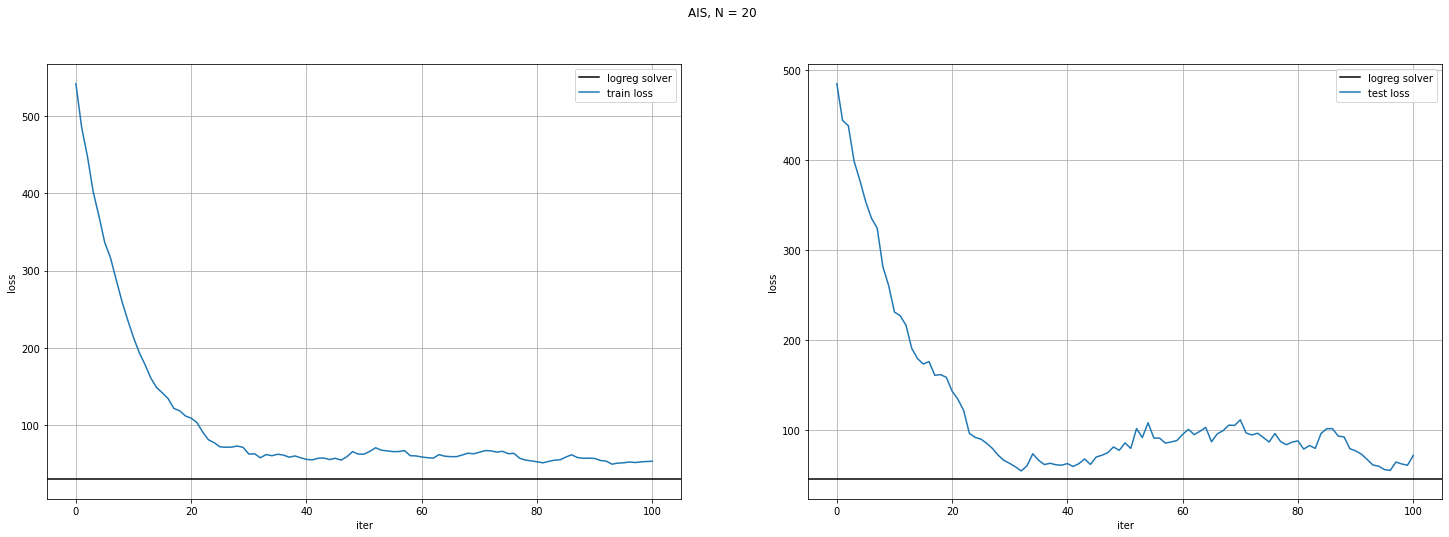

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [28]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.8896551724137931
0.7619047619047619


In [29]:
n_steps = 100
grad_step = 1e-2 #5e-6
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1., T)[::-1]

#start = torch.zeros((1, len(betas), dim))
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)
#start = proposal.sample([batch_size, len(betas)])
#start = torch.zeros((1, len(betas), dim))
start = w_clf.unsqueeze(1).repeat(1, len(betas), 1)
start.requires_grad_(True)
history = ais_dynamics(start, target.log_prob, proposal, n_steps, grad_step, eps_scale, N, betas, rhos)

100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


In [30]:
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 29.693052, Test loss 45.544350
Iter: 1, Training loss: 29.693052, Test loss 45.544350
Iter: 2, Training loss: 29.693052, Test loss 45.544350
Iter: 3, Training loss: 29.693052, Test loss 45.544350
Iter: 4, Training loss: 31.387947, Test loss 38.137482
Iter: 5, Training loss: 31.387947, Test loss 38.137482
Iter: 6, Training loss: 31.387947, Test loss 38.137482
Iter: 7, Training loss: 31.387947, Test loss 38.137482
Iter: 8, Training loss: 31.387947, Test loss 38.137482
Iter: 9, Training loss: 31.387947, Test loss 38.137482
Iter: 10, Training loss: 34.281212, Test loss 33.277370
Iter: 11, Training loss: 37.234695, Test loss 31.319578
Iter: 12, Training loss: 37.234695, Test loss 31.319578
Iter: 13, Training loss: 37.234695, Test loss 31.319578
Iter: 14, Training loss: 37.234695, Test loss 31.319578
Iter: 15, Training loss: 37.234695, Test loss 31.319578
Iter: 16, Training loss: 37.234695, Test loss 31.319578
Iter: 17, Training loss: 37.234695, Test loss 31.319578
It

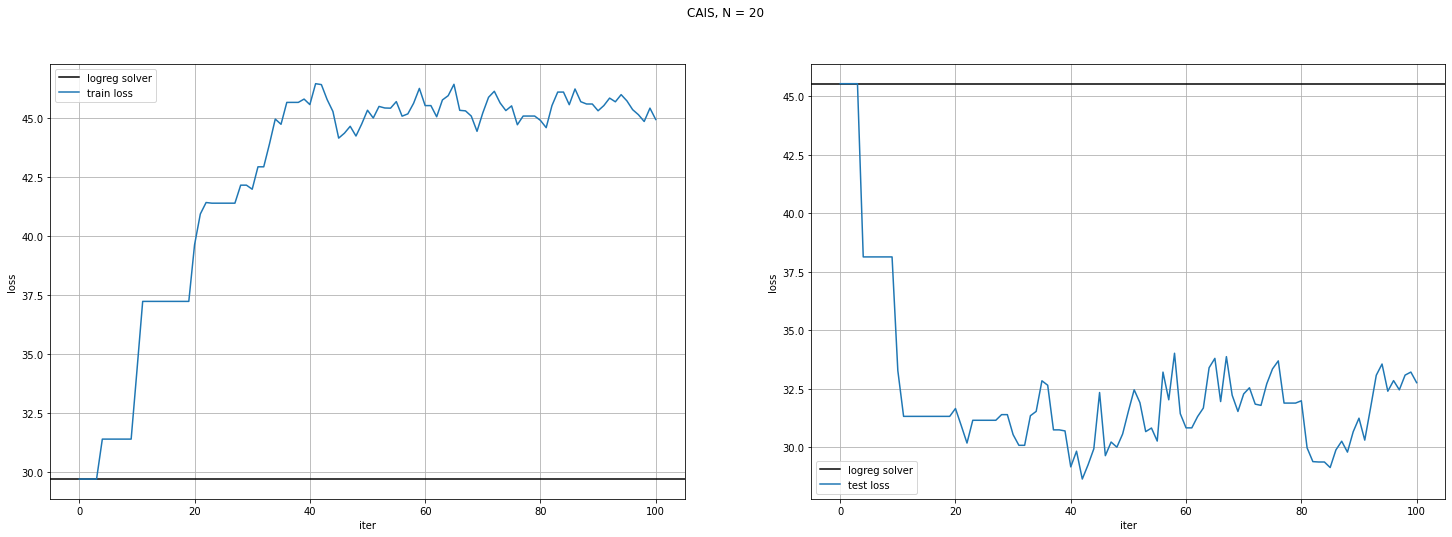

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'CAIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [32]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9172413793103448
0.7142857142857143


In [33]:
n_steps = 100
grad_step = 1e-2
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1., T)[::-1]

#start = torch.zeros((1, len(betas), dim))
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)

start = proposal.sample([batch_size, len(betas)])
#start = torch.zeros((1, len(betas), dim))

start.requires_grad_(True)
history = ais_dynamics(start, target.log_prob, proposal, n_steps, grad_step, eps_scale, N, betas, rhos)

100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


In [34]:
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 114.338341, Test loss 59.136475
Iter: 1, Training loss: 94.017189, Test loss 49.227379
Iter: 2, Training loss: 77.327499, Test loss 40.597084
Iter: 3, Training loss: 46.840137, Test loss 30.237078
Iter: 4, Training loss: 47.408634, Test loss 30.368298
Iter: 5, Training loss: 47.464828, Test loss 29.350235
Iter: 6, Training loss: 48.939926, Test loss 31.397354
Iter: 7, Training loss: 47.682842, Test loss 31.881678
Iter: 8, Training loss: 46.217228, Test loss 31.672291
Iter: 9, Training loss: 45.745586, Test loss 29.901726
Iter: 10, Training loss: 45.718735, Test loss 30.345190
Iter: 11, Training loss: 45.440788, Test loss 29.632162
Iter: 12, Training loss: 45.183273, Test loss 28.928228
Iter: 13, Training loss: 46.374432, Test loss 28.631189
Iter: 14, Training loss: 45.317303, Test loss 29.035648
Iter: 15, Training loss: 45.233131, Test loss 29.706205
Iter: 16, Training loss: 45.768730, Test loss 31.106249
Iter: 17, Training loss: 45.809132, Test loss 30.855385
I

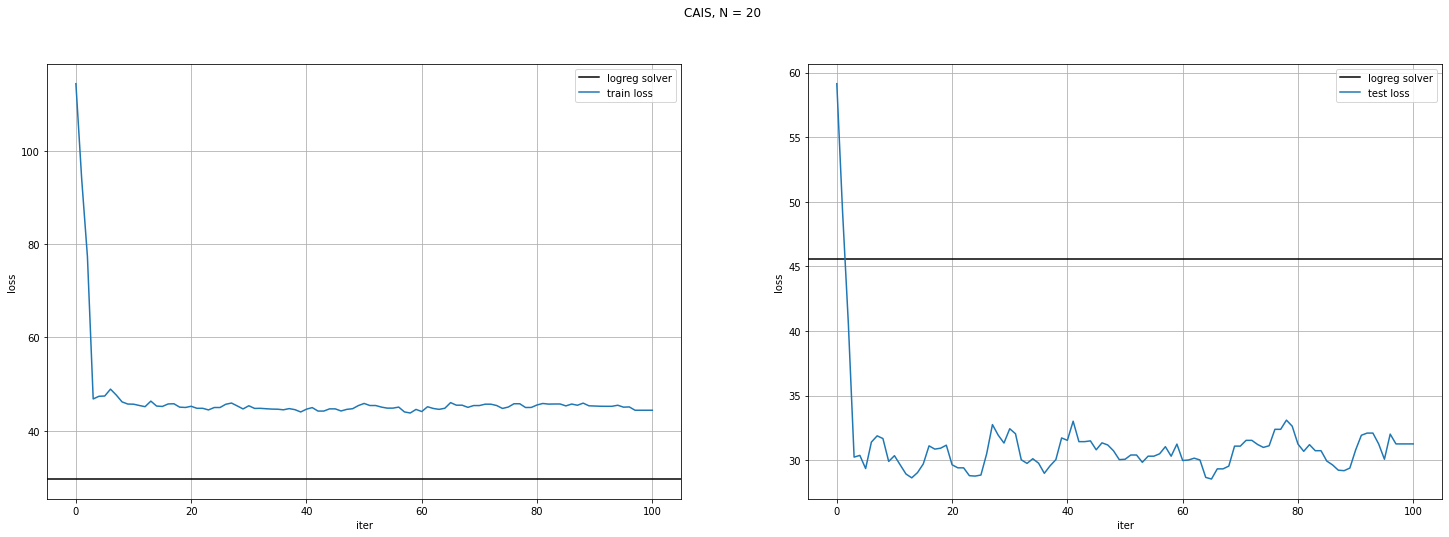

In [35]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'CAIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [36]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9172413793103448
0.746031746031746
